In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import seaborn as sns

In [54]:
# import date range for each winter by day
w22_dates = pd.date_range(start='2021-12-01', end='2022-03-31', freq='D')
w23_dates = pd.date_range(start='2022-12-01', end='2023-03-31', freq='D')

# import large sublimation events
w22_long_sublimation_events = pd.read_csv('./01_data/processed_data/sublimation/w22_long_evts.csv', index_col=0, parse_dates=True)
w22_short_sublimation_events = pd.read_csv('./01_data/processed_data/sublimation/w22_spiky_evts.csv', index_col=0, parse_dates=True)
w22_short_sublimation_events = w22_short_sublimation_events.loc['2022-01-01':'2022-03-31']

w23_long_sublimation_events = pd.read_csv('./01_data/processed_data/sublimation/w23_long_evts.csv', index_col=0, parse_dates=True)
w23_short_sublimation_events = pd.read_csv('./01_data/processed_data/sublimation/w23_spiky_evts.csv', index_col=0, parse_dates=True)

# import precipitation data
w22_precip = pd.read_csv('./01_data/processed_data/precipitation/w22_all_precip_30min.csv', index_col=0, parse_dates=True)
w23_precip = pd.read_csv('./01_data/processed_data/precipitation/w23_all_precip_30min.csv', index_col=0, parse_dates=True)
# w22_precip = xr.open_dataset('./01_data/processed_data/precipitation/w22_SAIL_gts_pluvio_1H.nc')['accum_rtnrt']
# w23_precip = xr.open_dataset('./01_data/processed_data/precipitation/w23_SAIL_gts_pluvio_1H.nc')['accum_rtnrt']

# import temperature data
w22_met_data = xr.open_dataset('./01_data/processed_data/splash/w22_splash_ap_qc_30min.nc')['temp']
w23_met_data = xr.open_dataset('./01_data/processed_data/sos/sos_ds_30M_storage.nc')['T_3m_c']

# import sublimation data
w22_sublimation = pd.read_csv('./01_data/processed_data/sublimation/w22_winter_sublimation.csv', index_col=0, parse_dates=True).loc['2021-12-01':'2022-03-31']
w23_sublimation = pd.read_csv('./01_data/processed_data/sublimation/w23_winter_sublimation.csv', index_col=0, parse_dates=True).loc['2022-12-01':'2023-03-31']

In [55]:
# resample precip to daily totals
w22_precip_daily = w22_precip.resample('D').sum().loc[w22_dates]
w23_precip_daily = w23_precip.resample('D').sum().loc[w23_dates]

# resample temperature to 7D rolling mean
w22_met_data_7d = w22_met_data.resample(time='1D').mean().rolling(time=7).mean().loc[w22_dates]
w23_met_data_7d = w23_met_data.resample(time='1D').mean().rolling(time=7).mean().loc[w23_dates]

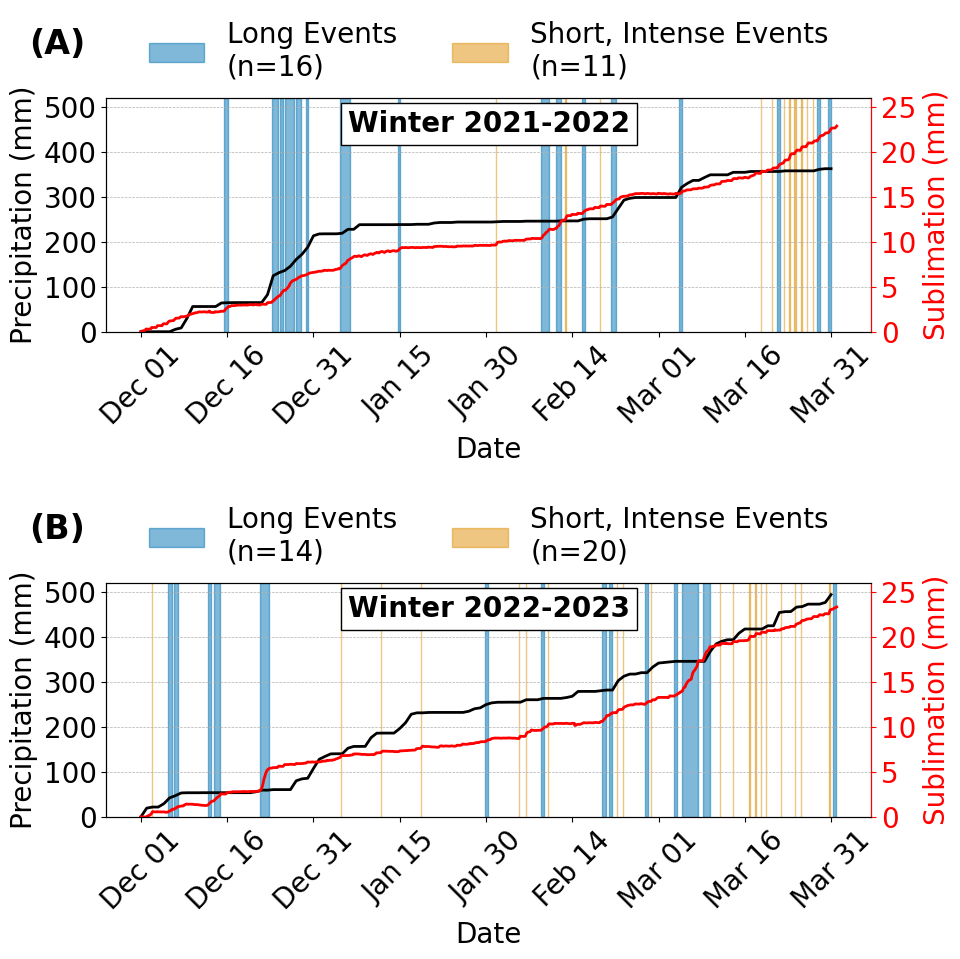

In [57]:
save_fig = True
# ── 1) set a global default ──────────────────────────────────────
plt.rcParams.update({
    "font.size": 20,        # everything: tick labels, legend text, etc.
    "axes.titlesize": 20,
    "axes.labelsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20,
})
# create figure
fig, axs = plt.subplots(2, 1, figsize= (10,10), tight_layout=True)

# fill the background with the sublimation event spans
for event in w22_long_sublimation_events.event_number.unique():
    axs[0].axvspan(w22_long_sublimation_events[w22_long_sublimation_events['event_number'] == event].index[0], 
                   w22_long_sublimation_events[w22_long_sublimation_events['event_number'] == event].index[-1],
                   color=sns.color_palette(palette='colorblind')[0], 
                   alpha=0.5)
n_long_events = len(w22_long_sublimation_events.event_number.unique())
for event in w22_short_sublimation_events.event_number.unique():
    if event > 4:
        axs[0].axvspan(w22_short_sublimation_events[w22_short_sublimation_events['event_number'] == event].index[0], 
                    w22_short_sublimation_events[w22_short_sublimation_events['event_number'] == event].index[-1],
                    color=sns.color_palette(palette='colorblind')[1], 
                    alpha=0.5)
n_short_events = len(w22_short_sublimation_events.event_number.unique())


# plot cumulative precipitation
axs[0].plot(w22_precip_daily.index, 
            w22_precip_daily['SAIL_gts_pluvio'].cumsum(), 
            color='black', 
            lw=2,
            )

# plot cumulative sublimation
ax2_0 = axs[0].twinx()
ax2_0.plot(w22_sublimation.index, 
           w22_sublimation['sublimation_prcp_0_5_mm'].interpolate().cumsum(), 
           color='red',
           lw=2
           )
ax2_0.set_ylim(0, 26)
ax2_0.set_ylabel('Sublimation (mm)', color='red')

# change color of spine and ticks to match line color
ax2_0.spines['right'].set_color('red')
ax2_0.yaxis.label.set_color('red')
ax2_0.tick_params(axis='y', colors='red')
ax2_0.set_yticks(np.arange(0, 26, 5))
# rotate x-axis labels
labels = axs[0].set_xticks(w22_precip_daily.index[::15])
axs[0].set_xticklabels(labels=w22_precip_daily.index.strftime('%b %d')[::15], rotation=45);

# create a legend for the sublimation events
axs[0].axvspan(None,None, color=sns.color_palette(palette='colorblind')[0], alpha=0.5, label='Long Events\n(n={})'.format(n_long_events))
axs[0].axvspan(None,None, color=sns.color_palette(palette='colorblind')[1], alpha=0.5, label='Short, Intense Events\n(n={})'.format(n_short_events))
axs[0].legend(loc='center', bbox_to_anchor=(0.5, 1.2), ncol=2, frameon=False)

# --------------- second plot for 2023 ----------------
# fill the background with the sublimation event spans
for event in w23_long_sublimation_events.event_number.unique():
    axs[1].axvspan(w23_long_sublimation_events[w23_long_sublimation_events['event_number'] == event].index[0], 
                   w23_long_sublimation_events[w23_long_sublimation_events['event_number'] == event].index[-1],
                   color=sns.color_palette(palette='colorblind')[0], 
                   alpha=0.5)
n_long_events = len(w23_long_sublimation_events.event_number.unique())

for event in w23_short_sublimation_events.event_number.unique():
    axs[1].axvspan(w23_short_sublimation_events[w23_short_sublimation_events['event_number'] == event].index[0], 
                   w23_short_sublimation_events[w23_short_sublimation_events['event_number'] == event].index[-1],
                   color=sns.color_palette(palette='colorblind')[1], 
                   alpha=0.5)
n_short_events = len(w23_short_sublimation_events.event_number.unique())

# plot a bar plot of precipitation
axs[1].plot(w23_precip_daily.index, 
            w23_precip_daily['SAIL_gts_pluvio'].cumsum(), 
            color='black', 
            lw=2)

# plot cumulative sublimation
ax2_1 = axs[1].twinx()
ax2_1.plot(w23_sublimation.index, 
           w23_sublimation['sublimation_prcp_0_5_mm'].interpolate().cumsum(), 
           color='red',
           lw=2)
ax2_1.set_ylim(0, 26)
ax2_1.set_ylabel('Sublimation (mm)', color='red')
ax2_1.set_yticks(np.arange(0, 26, 5))
# change color of spine and ticks to match line color
ax2_1.spines['right'].set_color('red')
ax2_1.yaxis.label.set_color('red')
ax2_1.tick_params(axis='y', colors='red')

# rotate x-axis labels
labels = axs[1].set_xticks(w23_precip_daily.index[::15])
axs[1].set_xticklabels(labels=w23_precip_daily.index.strftime('%b %d')[::15], rotation=45);

# add (A) and (B) and text in the upper left corner of each subplot
axs[0].text(-0.1, 1.3, '(A)', 
              transform=axs[0].transAxes, 
              fontsize=24, 
              fontweight='bold', 
              va='top', 
              ha='left')
axs[1].text(-0.1, 1.3, '(B)',
            transform=axs[1].transAxes, 
              fontsize=24, 
              fontweight='bold', 
              va='top', 
              ha='left')

# create a legend for the sublimation events
axs[1].axvspan(None,None, color=sns.color_palette(palette='colorblind')[0], alpha=0.5, label='Long Events\n(n={})'.format(n_long_events))
axs[1].axvspan(None,None, color=sns.color_palette(palette='colorblind')[1], alpha=0.5, label='Short, Intense Events\n(n={})'.format(n_short_events))
axs[1].legend(loc='center', bbox_to_anchor=(0.5, 1.2), ncol=2, frameon=False)

# add text box in white with black border for winter 2021-2022 and 2022-2023
axs[0].text(0.5, 0.95, 'Winter 2021-2022', 
            transform=axs[0].transAxes, 
            fontsize=20,
            fontweight='bold',
            va='top',
            ha='center',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.25'))
axs[1].text(0.5, 0.95, 'Winter 2022-2023', 
            transform=axs[1].transAxes, 
            fontsize=20,
            fontweight='bold',
            va='top',
            ha='center',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.25'))

# for both axes
for ax in axs:
    ax.set_ylim(0,520)
    ax.set_yticks(np.arange(0, 501, 100))
    ax.set_ylabel('Precipitation (mm)')
    ax.set_xlabel('Date')
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=1.)

if save_fig:
    # save the figure
    fig.savefig('04_products/figures/draft/sublimation_event_summary.png', dpi=300)
    

In [60]:
# calculate the percent of each event type that had precipitation occur in the prior 24 hours.
# use event number to get the first instance of each event number
def get_event_starts(events):
    event_starts = []
    for event in events.event_number.unique():
        event_starts.append(events[events['event_number'] == event].index[-1])
    return pd.to_datetime(event_starts)

def get_precip_before_event(events, precip_data, hours=24):
    """
    Get the precipitation that occurred in the specified number of hours before each event start.
    
    Parameters:
    events (pd.DataFrame): DataFrame containing event data with a 'start' column.
    precip_data (pd.DataFrame): DataFrame containing precipitation data indexed by time.
    hours (int): Number of hours before the event to check for precipitation.
    
    Returns:
    list: List of precipitation amounts for each event start.
    """
    event_starts = get_event_starts(events)
    precip_before_events = []
    for start in event_starts:
        precip_amount = precip_data['SAIL_gts_pluvio'].loc[start - pd.Timedelta(hours=hours):start].sum()
        precip_before_events.append(precip_amount)
    return pd.Series(precip_before_events, index=event_starts)

w22_long_sublimation_events_starts = get_event_starts(w22_long_sublimation_events)
w22_short_sublimation_events_starts = get_event_starts(w22_short_sublimation_events)
w23_long_sublimation_events_starts = get_event_starts(w23_long_sublimation_events)
w23_short_sublimation_events_starts = get_event_starts(w23_short_sublimation_events)

# using the 30-minute precipitation data, get the precipitation that occurred in the 24 hours prior to each event start
w22_long_event_precip_24h = get_precip_before_event(w22_long_sublimation_events, w22_precip, hours=24)
w22_short_event_precip_24h = get_precip_before_event(w22_short_sublimation_events, w22_precip, hours=24)
w23_long_event_precip_24h = get_precip_before_event(w23_long_sublimation_events, w23_precip, hours=24)
w23_short_event_precip_24h = get_precip_before_event(w23_short_sublimation_events, w23_precip, hours=24)    

# calculate the percent of events that had precipitation in the 24 hours prior
w22_long_event_precip_24h_percent = (w22_long_event_precip_24h>0.05).sum() / len(w22_long_sublimation_events_starts) * 100
w22_short_event_precip_24h_percent = (w22_short_event_precip_24h>0.05).sum() / len(w22_short_sublimation_events_starts) * 100
w23_long_event_precip_24h_percent = (w23_long_event_precip_24h>0.05).sum() / len(w23_long_sublimation_events_starts) * 100
w23_short_event_precip_24h_percent = (w23_short_event_precip_24h>0.05).sum() / len(w23_short_sublimation_events_starts) * 100

print(f'Percent of long sublimation events in winter 2022 that had precipitation in the 24 hours prior: {w22_long_event_precip_24h_percent:.2f}%')
print(f'Percent of short sublimation events in winter 2022 that had precipitation in the 24 hours prior: {w22_short_event_precip_24h_percent:.2f}%')
print(f'Percent of long sublimation events in winter 2023 that had precipitation in the 24 hours prior: {w23_long_event_precip_24h_percent:.2f}%')
print(f'Percent of short sublimation events in winter 2023 that had precipitation in the 24 hours prior: {w23_short_event_precip_24h_percent:.2f}%')

Percent of long sublimation events in winter 2022 that had precipitation in the 24 hours prior: 62.50%
Percent of short sublimation events in winter 2022 that had precipitation in the 24 hours prior: 18.18%
Percent of long sublimation events in winter 2023 that had precipitation in the 24 hours prior: 78.57%
Percent of short sublimation events in winter 2023 that had precipitation in the 24 hours prior: 75.00%
